# Diffusion Map


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm 
import warnings
from math import*
import copy

from sklearn.datasets import make_swiss_roll
from sklearn.datasets import make_blobs

## create test data

In [2]:
X, color = make_swiss_roll(n_samples=1000, noise=0.1, hole=True)
#X, color = make_blobs(n_samples=1000, n_features=3)


def create_helix(radius, height,num_wobels, num_points):
    theta = np.linspace(0, 2 * np.pi, num_points)  # Angle values
    z = np.linspace(0, 0, num_points) + height*np.sin(theta*num_wobels)  # Height values
    x = radius * np.cos(theta)  # X-coordinates
    y = radius * np.sin(theta)  # Y-coordinates

    # Calculate the helix coordinates
    coordinates = np.column_stack((x, y, z))

    return coordinates

#X = create_helix(1, 10,6, 1000)

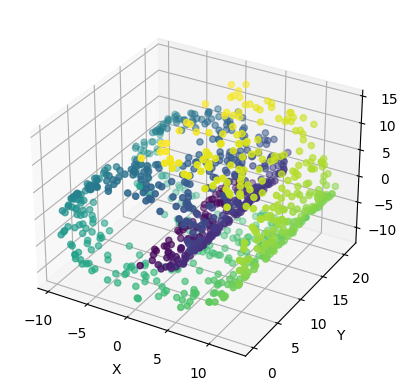

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

## Compute diffusion map (https://www.kaggle.com/code/rahulrajpl/diffusion-map-for-manifold-learning)


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from scipy.linalg import eigh
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings


In [5]:
def find_diffusion_matrix(X=None, alpha=0.25):
    """Function to find the diffusion matrix P
        
        >Parameters:
        alpha - to be used for gaussian kernel function
        X - feature matrix as numpy array
        
        >Returns:
        P_prime, P, Di, K, D_left
    """
    alpha = alpha
        
    dists = euclidean_distances(X, X)
    K = np.exp(-dists**2 / alpha)
    
    r = np.sum(K, axis=0)
    Di = np.diag(1/r)
    P = np.matmul(Di, K)
    
    D_right = np.diag((r)**0.5)
    D_left = np.diag((r)**-0.5)
    P_prime = np.matmul(D_right, np.matmul(P,D_left))

    return P_prime, P, Di, K, D_left


def find_diffusion_map(P_prime, D_left, n_eign=3):
    """Function to find the diffusion coordinates in the diffusion space
        
        >Parameters:
        P_prime - Symmetrized version of Diffusion Matrix P
        D_left - D^{-1/2} matrix
        n_eigen - Number of eigen vectors to return. This is effectively 
                    the dimensions to keep in diffusion space.
        
        >Returns:
        Diffusion_map as np.array object
    """   
    n_eign = n_eign
    
    eigenValues, eigenVectors = eigh(P_prime)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    diffusion_coordinates = np.matmul(D_left, eigenVectors)
    
    return diffusion_coordinates[:,:n_eign]

In [6]:
def plot_3Dfigure(newX, title='Datapoints'):
    data = go.Scatter3d(x=newX[:,0], y=newX[:,1], z=newX[:,2], mode='markers', marker=dict(
            size=2,color=newX[:,1],opacity=0.7,colorscale='Viridis'))
    layout = go.Layout(title_text=title,title_x=0.5,title_y=0.8,title_font_size=12)
    fig = go.Figure(data=[data], layout=layout)
    fig.update_layout(showlegend=False)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(scene = dict(
                    xaxis = dict(title= '', ticks= '', showticklabels= False,),
                    yaxis = dict(title= '', ticks= '', showticklabels= False,),
                    zaxis = dict(title= '', ticks= '', showticklabels= False,),
                    ))
                  
    fig.show()

In [7]:
def plot_2Dsub_figures(d_map, alpha_values, title='Diffused points'):
    subplot_titles=[f'α={round(a,4)}' for a in alpha_values]
    fig = make_subplots(rows=2, cols=5,subplot_titles=subplot_titles)
    for i in range(1,3):
        for j in range(1,6):
            dmap_idx = i+j-1
            fig.add_trace(
                go.Scatter(x=d_map[dmap_idx][:,0], y=d_map[dmap_idx][:,1], mode='markers', marker=dict(
                size=3,color=d_map[dmap_idx][:,1],opacity=0.8,colorscale='Viridis')),row=i, col=j)

    fig.update_layout(title_text=title, title_x=0.5)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(height=500, width=1000, showlegend=False)
    fig.show()

In [8]:
def apply_diffusions(alpha_start=0.001, alpha_end= 0.009, title='Diffused points'):
    d_maps = []
    alpha_values = np.linspace(alpha_start, alpha_end, 10)
    for alpha in alpha_values:
        P_prime, P, Di, K, D_left = find_diffusion_matrix(newX, alpha=alpha)
        d_maps.append(find_diffusion_map(P_prime, D_left, n_eign=2))
    return d_maps, alpha_values

In [9]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(X, alpha=1.6)
dm = find_diffusion_map(P_prime, D_left, n_eign=2)

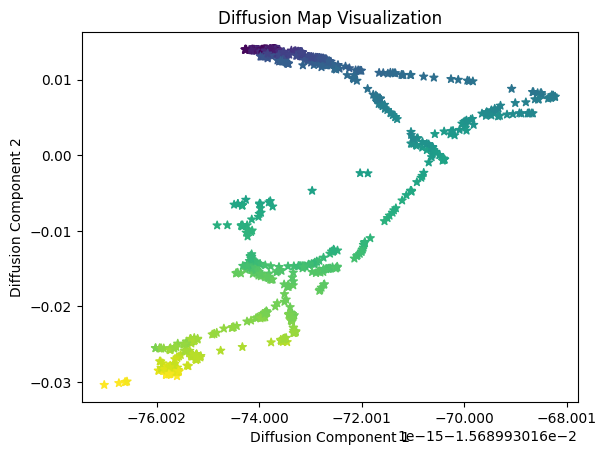

In [10]:
plt.scatter(dm[:, 0], dm[:, 1],marker = "*",c=color)
plt.xlabel('Diffusion Component 1')
plt.ylabel('Diffusion Component 2')
plt.title('Diffusion Map Visualization')
plt.show()

## Compute diffusion map (package)

In [21]:
import pydiffmap 
from pydiffmap.visualization import embedding_plot, data_plot

In [22]:
#https://pydiffmap.readthedocs.io/en/master/usage.html
mydmap = pydiffmap.diffusion_map.DiffusionMap.from_sklearn(n_evecs = 997, epsilon = 1.2, alpha = 0, k=100)

In [23]:
mydmap.fit(X)

In [24]:
dmap = mydmap.fit_transform(X)

Text(0.5, 0.92, 'Diffusion Map Visualization')

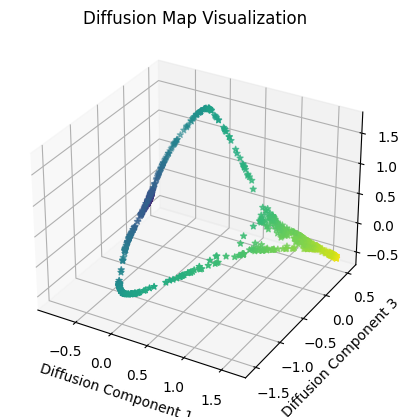

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(dmap[:, 0], dmap[:, 1],dmap[:, 2],marker = "*",c=color)
ax.set_xlabel('Diffusion Component 1')
ax.set_ylabel('Diffusion Component 2')
ax.set_ylabel('Diffusion Component 3')
ax.set_title('Diffusion Map Visualization')

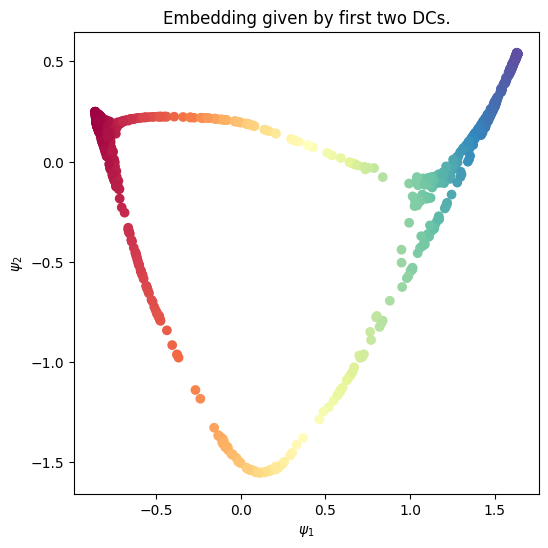

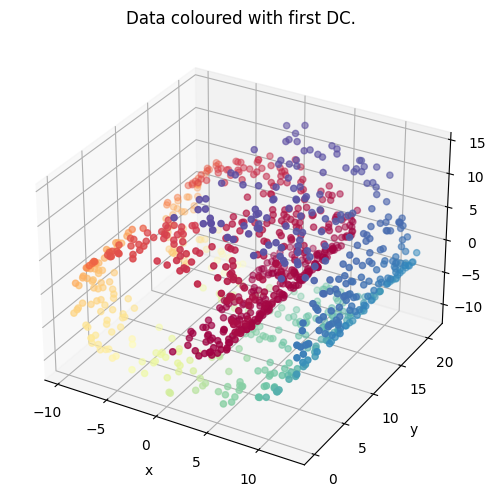

In [26]:
embedding_plot(mydmap, scatter_kwargs = {'c': dmap[:,0], 'cmap': 'Spectral'}, dim=2)
data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})
plt.show()

## Compute diffusion map (own)

In [ ]:
def save_matrix(M,name = "test", folder_name = "diffusion_map"):
    df = pd.DataFrame(M,copy=True)
    df.to_csv(folder_name + "/" + name + ".csv")

In [ ]:
#Define data Matrix A
#TESTED

#A = df.loc[0:2000,"pc1":"pc2"]
#A = df.loc[0:2000,"v2x_suffr":"v2elfrfair"]
#A = df
A = pd.DataFrame(X)

save_matrix(A,name = "A", folder_name = "diffusion_map")

#Size of Matrix A
M = A.shape[0] #Number of OAs (OutputAreas) - Zeilen/Rows
N = A.shape[1] #Number of variables - Spalten/Columns

print(str(M) + " Output Areas, " + str(N) + " Variables")
print()

#Standardize A, so that the mean is 0 and the standard deviation is 1 (mean 0, sd 1)
print("Mean and standard deviation before standardizing:")
for n in range(N): #for all variables in dataset
    mean = np.mean(A.iloc[:,n])
    sd = np.std(A.iloc[:,n])
    
    print("Before standardizing: column: " + str(n) + ", mean = " + str(mean) + ", standard deviation = " + str(sd))
    
    for m in range(M): #adapt all entries
        A.iat[m,n] = (A.iat[m,n] - mean)/sd  
        
    mean = np.mean(A.iloc[:,n])
    sd = np.std(A.iloc[:,n])        
    print("After standardizing: column: " + str(n) + ", mean = " + str(mean) + ", standard deviation = " + str(sd))    
    
save_matrix(A,name = "A_stand", folder_name = "diffusion_map")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(A.iloc[:, 0], A.iloc[:, 1], A.iloc[:, 2], c=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Swiss Roll Data')

# Show the plot
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(A.iloc[:, 0], A.iloc[:, 2], c=color)

# Show the plot
plt.show()

In [ ]:
#Compute Euclidean distances between data points (Distance Matrix D)
#TESTED

from sklearn.metrics.pairwise import pairwise_distances
D = pairwise_distances(A, metric='euclidean') 

save_matrix(D,name = "D")

#D = pd.DataFrame(np.zeros((M,M))) #Distance Matrix

#for i in tqdm (range(M), desc= "Compute..." ): #for each row/column in D
#    for j in range(M): #for each row/column in D
#        d = 0
#        for n in range(N):
#            d = d + pow(A.iat[i,n] - A.iat[j,n],2)
            
#        D.iat[i,j] = sqrt(d)

#print(D)

In [ ]:
#Construct a similarity matrix C
#TESTED
#kernal: gaussian

epsilon = 0.2
C = np.zeros((M,M))

for i in tqdm(range(M), desc = "Compute..."):
    for j in range(i+1):
        val = exp(-D[i,j]**2/(epsilon))
        C[i,j] = val
        C[j,i] = val



save_matrix(C,name = "C", folder_name = "diffusion_map")

In [ ]:
'''
#Construct a similarity matrix C
C = np.zeros((M,M))

number_points_with_zero_distance = 0 #count events, where 
max_value_C = 0 #max similarity value which will replace 1/0 entries

for i in tqdm (range(M), desc= "Compute..." ):
    for j in range(i):
        #if i==j C stays 0; for i!=j is:
        if i != j:
            d = D[i,j]
            if d != 0:
                C[i,j] = 1/d
                C[j,i] = C[i,j]
            else:
                C[i,j] = max_value_C
                C[j,i] = max_value_C
                number_points_with_zero_distance = number_points_with_zero_distance + 1                

msg = "There are " + str(number_points_with_zero_distance) + " Output Areas with distance 0."
warnings.warn(msg)
'''

In [ ]:
#Threshold the similarity matrix
#Treshold: Cij is kept, if its among 10 highest simularity scores for i and j
#Fourth, we threshold the data by setting most of the small entries of the similarity matrix C to zero. As it is hard to define an absolute threshold of similarity, we use a heuristic procedure in which an entry Cij is kept if it is among the top-10 highest similarity scores for either OA i or OA j. Otherwise, it is discarded and set to zero. This ensures that each node in the network has at least 10 links, while removing a large number of weak, low-similarity links, avoiding the curse of dimensionality, described above.


#delete entries which are below a treshold
for i in tqdm (range(M), desc= "Compute..." ):
    considered_sims = copy.deepcopy(C[i,:])
    considered_sims.sort()
    treshold = considered_sims[-100]
    for j in range(M):
        if C[i,j] < treshold:
            C[i,j] = 0

#keep a symetric matrix
for i in tqdm (range(M), desc= "Compute..." ):
    for j in range(M):
        if C[i,j] != 0:
            C[j,i] = C[i,j]
        
            

save_matrix(C,name = "C_tresh", folder_name = "diffusion_map")

In [ ]:
#Define a Laplacian matrix - Obtain the transitions matrix L by normalizing C
from sklearn.preprocessing import normalize
L = normalize(C, axis=1, norm='l1')

'''
L = np.zeros((M,M))

for j in tqdm (range(M), desc= "Compute..." ):
    s = sum(C[:,j])
    for i in range(M):
        L[i,j] = C[i,j]/s
'''
save_matrix(L,name = "L", folder_name = "diffusion_map")

In [ ]:
L = np.linalg.matrix_power(L,1000)

In [ ]:
# Perform eigenvalue decomposition

import scipy.sparse.linalg as spsl
eigenvalues, eigenvectors = np.linalg.eig(L)
#eigenvalues, eigenvectors = spsl.eigs(L, k=998, which='LR')

save_matrix(eigenvalues,name = "eigenvalues1", folder_name = "diffusion_map")
save_matrix(eigenvectors,name = "eigenvectors1", folder_name = "diffusion_map")

ix = eigenvalues.argsort()[::-1][1:]
eigenvalues = np.real(eigenvalues[ix])
eigenvectors = np.real(eigenvectors[:, ix])
diffusion_map = eigenvalues * eigenvectors
#diffusion_map = np.dot(eigenvectors, np.diag(-np.sqrt(1. / eigenvalues)))

save_matrix(diffusion_map,name = "diffusion_map", folder_name = "diffusion_map")
save_matrix(eigenvectors ,name = "sorted_eigenvectors ", folder_name = "diffusion_map")
save_matrix(eigenvalues,name = "sorted_eigenvalues", folder_name = "diffusion_map")

In [ ]:
# Plot eigenvalues

plt.scatter(list(range(len(eigenvalues)))[0:10:1],list(eigenvalues)[0:10:1],c=color[0:10:1])
plt.show()

In [ ]:
# Step 7: Visualize the diffusion map representation
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(diffusion_map[:, 0], diffusion_map[:, 1],diffusion_map[:, 2],marker = "*",c=color)
ax.set_xlabel('Diffusion Component 1')
ax.set_ylabel('Diffusion Component 2')
ax.set_ylabel('Diffusion Component 3')
ax.set_title('Diffusion Map Visualization')

In [ ]:
# Step 7: Visualize the diffusion map representation
plt.scatter(diffusion_map[:, 0], diffusion_map[:, 1],marker = "*",c=color)
plt.xlabel('Diffusion Component 1')
plt.ylabel('Diffusion Component 2')
plt.title('Diffusion Map Visualization')
plt.show()

In [ ]:
# Step 7: Visualize the diffusion map representation
plt.scatter(diffusion_map[:, 1], diffusion_map[:, 2],marker = "*",c=color)
plt.xlabel('Diffusion Component 2')
plt.ylabel('Diffusion Component 3')
plt.title('Diffusion Map Visualization')
plt.show()

In [ ]:
# Step 7: Visualize the diffusion map representation
plt.scatter(diffusion_map[:, 2], diffusion_map[:, 3],marker = "*",c=color)
plt.xlabel('Diffusion Component 3')
plt.ylabel('Diffusion Component 4')
plt.title('Diffusion Map Visualization')
plt.show()

In [ ]:
N